In [24]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import mlflow

In [25]:
# Lancer MLFlow sur le port 5001 : mlflow ui --port 5001
mlflow.set_tracking_uri("http://127.0.0.1:5001")
mlflow.set_experiment("Monitoring des perf des modèles PCO")

<Experiment: artifact_location='mlflow-artifacts:/660506006876858877', creation_time=1730817563899, experiment_id='660506006876858877', last_update_time=1730817563899, lifecycle_stage='active', name='Monitoring des perf des modèles PCO', tags={}>

# RFC 1

In [26]:
arr_algo_1 = np.load('array_algo_1.npy', allow_pickle=True)
arr_algo_1[0, 0:5]

array([8600432.0, 'Description du poste', 0, 0.24681146442890167,
       0.05224579572677612], dtype=object)

In [27]:
df_algo_1 = pd.DataFrame(arr_algo_1)
nb_cat_bin = df_algo_1[2].value_counts()
nb_cat_bin

2
1    1859
0    1752
Name: count, dtype: int64

## Préparation du dataset

In [28]:
X = arr_algo_1[:, 3:] # vecteurs d'embedding
Y = arr_algo_1[:, 2] # variable cible 0 / 1

In [29]:
X = X.astype(float)
Y = Y.astype(int)
print(X.dtype)
print(Y.dtype)

float64
int32


In [30]:
# seed random
import random

seed = random.randint(0, 1000)
print(f"Seed utilisée : {seed}")

Seed utilisée : 986


In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=seed, stratify=Y)

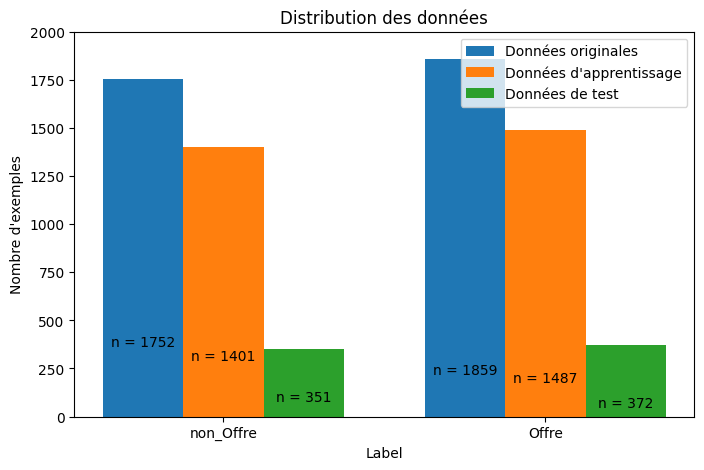

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5), dpi=100)

plt.title("Distribution des données")

plt.hist([Y, y_train, y_test],
         bins = [x - 0.5 for x in range(0, 3)],
         rwidth=0.75,
         label=["Données originales", "Données d'apprentissage", "Données de test"])

plt.annotate("n = " + str(np.sum(Y == 0)), (-0.25, 365.0), ha='center')
plt.annotate("n = " + str(np.sum(y_train == 0)), (0.0, 293.0), ha='center')
plt.annotate("n = " + str(np.sum(y_test == 0)), (0.25, 80.0), ha='center')

plt.annotate("n = " + str(np.sum(Y == 1)), (0.75, 220.0), ha='center')
plt.annotate("n = " + str(np.sum(y_train == 1)), (1.0, 178.0), ha='center')
plt.annotate("n = " + str(np.sum(y_test == 1)), (1.25, 50.0), ha='center')

plt.xticks(np.arange(2), ("non_Offre", "Offre"))

plt.xlabel("Label")
plt.ylabel("Nombre d'exemples")

plt.ylim(0.0, 2000.0)

plt.legend()

plt.show()

## Recherche meilleurs hyperparamètres

In [33]:
from sklearn.ensemble import RandomForestClassifier

# Entrainement avec meilleurs hyperparamètres

## Prédictions jeu de train

## Prédictions jeu de test

In [34]:
from mlflow.models.signature import infer_signature

with mlflow.start_run(run_name="model_metrics_train_1") as run:
    print(f"Tracking URI: {mlflow.get_tracking_uri()}")
    best_n_estim = 600
    best_max_depth = 30

    # Définir et entraîner le modèle
    rfc = RandomForestClassifier(
        # class_weight='balanced',
        n_estimators=best_n_estim,
        max_depth=best_max_depth,
        bootstrap=True,
        random_state=seed,
        oob_score=True
    )

    rfc.fit(X_train, y_train)
    print(f"Erreur OOB : {1 - rfc.oob_score_}")

    y_pred = rfc.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1)

    # Inférer la signature une fois le modèle entraîné
    X_train_df = pd.DataFrame(X_train)
    input_example = X_train_df.sample(1)  # Exemple d'entrée (une seule ligne)
    signature = infer_signature(X_train_df, rfc.predict(X_train))  # Signature

    # Logger les métriques
    mlflow.log_metric("accuracy_rfc_1", accuracy)
    mlflow.log_metric("precision_rfc_1", precision)
    mlflow.log_metric("recall_rfc_1", recall)
    mlflow.log_metric("f1_score_rfc_1", f1)

    # Logger les hyperparamètres
    mlflow.log_param("n_estimators_rfc_1", best_n_estim)
    mlflow.log_param("max_depth_rfc_1", best_max_depth)

    # Logger le modèle avec signature et exemple d'entrée
    mlflow.sklearn.log_model(
        rfc,
        "rfc_1",
        input_example=input_example,
        signature=signature
    )


Tracking URI: http://127.0.0.1:5001
Erreur OOB : 0.1575484764542936
Accuracy: 0.8533886583679114
Precision: 0.8481675392670157
Recall: 0.8709677419354839
F1-score: 0.8594164456233422


2024/11/17 11:34:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run model_metrics_train_1 at: http://127.0.0.1:5001/#/experiments/660506006876858877/runs/887bff6ead2b4df89edc724f042546b0.
2024/11/17 11:34:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5001/#/experiments/660506006876858877.


In [35]:
stop;:%|\

SyntaxError: invalid syntax (167484922.py, line 1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_train, labels=rfc.classes_, normalize='true')

NameError: name 'y_pred_train' is not defined

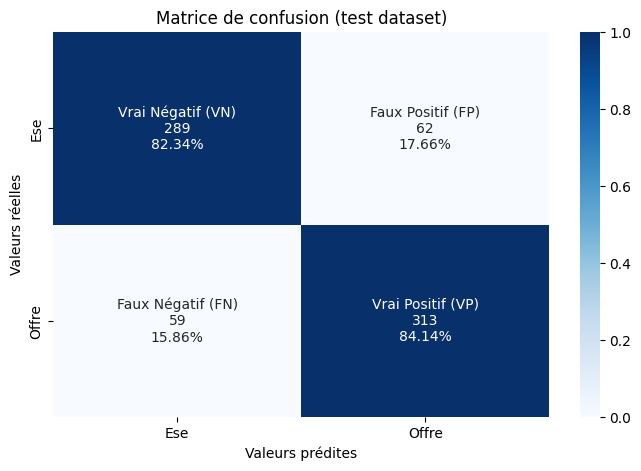

In [ ]:
import seaborn as sns

names = ['Vrai Négatif (VN)', 'Faux Positif (FP)','Faux Négatif (FN)', 'Vrai Positif (VP)']
counts = ["{0:0.0f}\n".format(value) for value in confusion_matrix(y_test, y_pred, normalize=None).flatten()]
percentages = ["{0:.2%}".format(value) for value in confusion_matrix(y_test, y_pred, normalize='true').flatten()]

box_labels = [f"{v1}\n{v2}{v3}" for v1, v2, v3 in zip(names, counts, percentages)]
box_labels = np.asarray(box_labels).reshape(cm.shape[0],cm.shape[1])

plt.figure(figsize=(8,5), dpi=100)

plt.title("Matrice de confusion (test dataset)")

sns.heatmap(cm,
            vmin=0.0,
            vmax=1.0,
            cmap='Blues',
            annot=box_labels,
            fmt='',
            xticklabels=['Ese', 'Offre'],
            yticklabels=['Ese', 'Offre'])

plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")

plt.show()

## Observations des mauvaises prédictions

In [ ]:
df_train, df_test = train_test_split(df_algo_1, test_size=0.20, random_state=seed, stratify=Y)
df_test['true']=y_test
df_test['pred']=y_pred

In [ ]:
# Faux négatifs
df_test.loc[(df_test['true'] == 1) & (df_test['pred'] == 0)]

,0,1,2,3,4,5,6,7,8,9,...,1019,1020,1021,1022,1023,1024,1025,1026,true,pred
337,3137618.0,selon profil et expérience,1,0.022218,0.246106,-0.838685,0.731438,0.174094,-0.188993,0.438757,...,-0.000534,0.029281,0.227131,0.262352,-0.92463,-0.166645,0.252049,-0.73878,1,0
1426,7692407.0,L' agence Régional Intérim de Vannes recrute dans le cadre d' un remplacement pour l' un de ses clients un Chaudronnier Soudeur H / F,1,0.391354,0.181815,0.100778,0.268846,0.067652,0.136128,-0.111097,...,-0.790858,0.293742,-0.051285,-0.299426,0.044903,-0.172047,0.163661,-0.322602,1,0
1249,3375269.0,Débutant accepté,1,0.094002,-0.064487,-0.238712,0.140275,0.040539,-0.0225,0.534766,...,-0.360279,0.610427,-0.710566,0.519541,-0.635559,-0.4825,0.098056,-0.163508,1,0
2178,7646574.0,Mission longue,1,0.586534,0.517816,-0.573137,-0.234405,0.129574,-0.386572,-0.117858,...,-0.116305,0.0074,-0.776138,-0.01171,-0.489288,0.172943,0.10616,-0.289974,1,0
1014,7198371.0,ADEVA PONTIVY recherche des monteurs de charpente métalliques,1,0.678915,0.559453,-0.112208,-0.134271,-0.079547,-0.217846,-0.125254,...,-0.272716,-0.097415,-0.03207,-0.170515,0.001754,-0.269174,-0.203261,-0.175962,1,0
3406,551956.0,Vous êtes curieux et en recherche constante de nouveauté,1,0.008148,-0.167345,-0.291929,0.473283,-0.330402,-0.071292,0.599989,...,0.063782,0.661264,-0.307508,0.091466,-0.322458,0.044458,-0.142089,0.274783,1,0
2412,2379792.0,Caractéristiques des tissus et matières textiles,1,-0.119975,0.172053,-0.392525,-0.196846,-0.604894,0.079593,-0.12761,...,-0.019162,0.12903,0.139086,0.213577,-0.034671,-0.391168,0.34844,-0.146826,1,0
1435,6483214.0,LEADER INTERIM recrute pour l' un de ses clients,1,0.69473,0.284524,0.110556,0.626894,-0.087949,-0.17211,-0.245004,...,-0.895631,0.193707,-0.517911,-0.177654,-0.413567,0.006404,-0.13504,-0.190487,1,0
2505,9074724.0,vous fédérez l' implication de vos collaborateurs à travers le développement de leurs compétences et,1,0.364589,-0.34916,-0.126469,-0.39783,-0.287628,-0.594275,0.249476,...,0.346758,-0.091804,-0.319401,-0.275996,0.189581,0.221259,0.079147,-0.168625,1,0
1922,8282371.0,Vous entretenez des relations durables avec nos clients et,1,-0.112996,-0.245971,-0.071575,-0.127159,0.107104,0.311698,-0.336343,...,-0.363061,0.109495,-0.162686,-0.11651,-0.222628,0.209693,0.730438,0.126575,1,0


In [ ]:
# Faux positifs
df_test.loc[(df_test['true'] == 0) & (df_test['pred'] == 1)]

## Enregistrement du modèle

In [ ]:
import joblib
from joblib import dump

#dump(rfc, 'rfc_1.joblib')

['rfc_1.joblib']